# Setup

## Imports

In [153]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## Set Parameters

NOTE: 1m data is only retrievable for the last 7 days, and any interval <1d is only for the last 60 days

In [ ]:
startDate = "2018-01-01"
endDate = "2020-01-01"
testStartDate = "2021-01-01"
testEndDate = "2024-01-01"
symbol1 = "PEP"
symbol2 = "KO"
timeInterval = "1d"

## Setup Data

In [155]:
# Download data for two stocks between specified dates with specified interval
data = yf.download([symbol1, symbol2], start=startDate, end=endDate, interval=timeInterval, auto_adjust=True)
# Get adjusted close prices
close = data["Close"].dropna()
close

[*********************100%***********************]  2 of 2 completed


Ticker,KO,PEP
Date,,
2018-01-02,36.016144,94.238091
2018-01-03,35.937061,93.990631
2018-01-04,36.443203,94.453636
2018-01-05,36.435295,94.725021
2018-01-08,36.379944,94.182220
...,...,...
2019-12-24,46.183338,116.246361
2019-12-26,46.445026,116.076515
2019-12-27,46.723583,116.798325


# Engle-Granger Test

## Imports

In [156]:
from statsmodels.tsa.stattools import adfuller

## Create Least Squares Linear Model and Get Residuals

In [157]:
# Convert prices from DataFrame to NumPy arrays
X = close[symbol1].to_numpy()
Y = close[symbol2].to_numpy()
# Regress Y on X
X_with_const = np.column_stack((np.ones(X.shape[0]), X))
beta, _, _, _ = np.linalg.lstsq(X_with_const, Y, rcond=None)
# Calculate residuals
residuals = Y - (beta[0] + beta[1] * X)
residuals

array([-1.97607857, -1.97428   , -1.61946958, -1.71607854, -1.59401763,
       -1.43561924, -1.40561098, -1.27278901, -1.31624203, -1.14095039,
       -1.25597521, -1.17460576, -1.24536809, -1.42097244, -1.31081944,
       -0.96856059, -0.89803475, -0.57670449, -0.68785159, -0.97459497,
       -0.93921637, -1.04993033, -1.19409826, -1.5509243 , -1.49010976,
       -1.56144375, -1.8421292 , -2.0871234 , -1.6184505 , -1.49926244,
       -0.77992609, -0.72740278, -0.59270643, -0.96344242, -1.09138408,
       -1.27775947, -0.97609634, -1.31272518, -1.62393904, -1.63765185,
       -1.25997732, -1.27243424, -1.24048611, -1.24826507, -1.40360876,
       -1.49407823, -1.32235686, -1.60690965, -1.79866653, -1.85761703,
       -1.78242653, -1.85798531, -1.68112764, -1.64002955, -1.46281024,
       -1.44402184, -1.31664492, -1.20288717, -1.26146292, -1.32313489,
       -1.22749423, -1.28193449, -1.0150697 , -0.85193765, -0.82678218,
       -0.87596172, -0.96880604, -0.84641141, -0.65717442, -0.52

## Plot Residuals

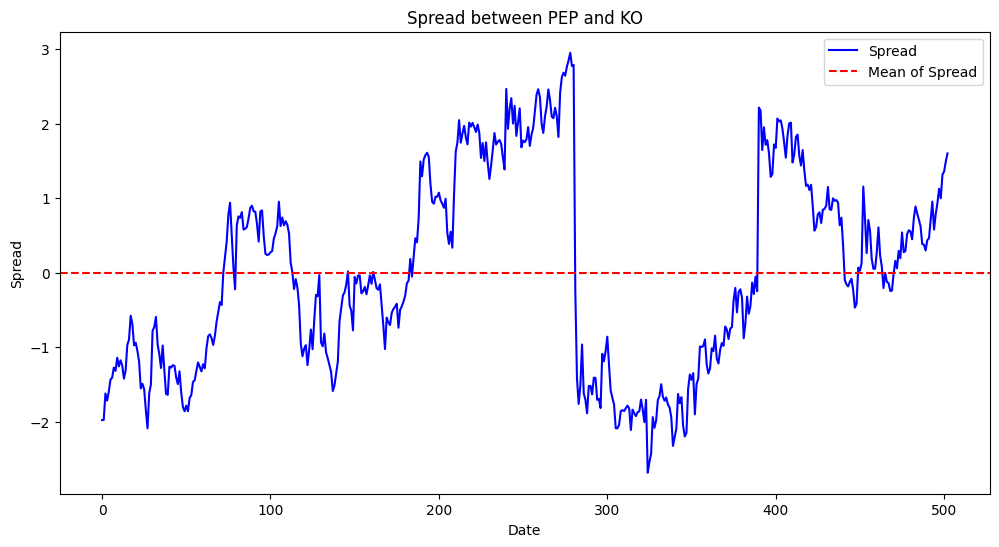

In [158]:
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Spread', color='blue')
plt.axhline(residuals.mean(), color='red', linestyle='--', label='Mean of Spread')
plt.title(f'Spread between {symbol1} and {symbol2}')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show() 

## Perform Augmented Dickey-Fuller Test

In [159]:
adfuller_result = adfuller(residuals)
# Print the ADF test statistic and p-value
print(f"ADF Test Statistic: {adfuller_result[0]}")
print(f"p-value: {adfuller_result[1]}")

ADF Test Statistic: -2.6660905092100915
p-value: 0.08009213104099261


# Backtesting

In [161]:
# Download data for two stocks between specified dates with specified interval
data = yf.download([symbol1, symbol2], start=testStartDate, end=testEndDate, interval=timeInterval, auto_adjust=True)
# Get adjusted close prices
close = data["Close"].dropna()
close

[*********************100%***********************]  2 of 2 completed


Ticker,KO,PEP
Date,,
2021-01-04,46.061344,126.083717
2021-01-05,45.554989,126.459511
2021-01-06,44.105755,124.912628
2021-01-07,43.616852,124.510635
2021-01-08,44.594646,126.005028
...,...,...
2023-12-22,55.780437,159.305069
2023-12-26,56.009991,160.426117
2023-12-27,56.153461,160.939163


In [162]:
def zscore(series, window=60):
    """
    Calculate the z-score of a series. Uses rolling mean and standard deviation over a 60-period window to avoid lookahead bias.
    
    Parameters:
        series (pd.Series): The input series to calculate the z-score for.
    
    Returns:
        float: The z-score of the series.
    """
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    z = (series - rolling_mean) / rolling_std
    return z

In [163]:
def backtest(spread, entry_threshold=2.0, exit_threshold=0.5, zscore_window=60):
    """
    Backtest a pairs trading strategy based on the spread z-score.
    
    Parameters:
        spread (pd.Series): The spread series.
        entry_threshold (float): The z-score threshold for opening a position.
        exit_threshold (float): The z-score threshold for closing a position.
    
    Returns:
        pd.DataFrame: A DataFrame with the backtest results.
    """
    signals = pd.DataFrame(index=spread.index, columns=['zscore', 'long_entry', 'short_entry', 'exit'])
    signals['zscore'] = zscore(spread, window=zscore_window)
    signals['long_entry'] = signals['zscore'] < -entry_threshold
    signals['short_entry'] = signals['zscore'] > entry_threshold
    signals['exit'] = (signals['zscore'] > -exit_threshold) & (signals['zscore'] < exit_threshold)
    
    return signals

In [164]:
def sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    """
    Calculate the Sharpe ratio of a series of returns.
    
    Parameters:
        returns (pd.Series): The series of returns.
        risk_free_rate (float): The risk-free rate of return.
        periods_per_year (int): The number of periods per year (e.g., 252 for daily returns).

    Returns:
        float: The Sharpe ratio.
    """
    excess_returns = returns - risk_free_rate / periods_per_year
    return np.mean(excess_returns) / np.std(excess_returns, ddof=1) * np.sqrt(periods_per_year)

def max_drawdown(equity_curve):
    """
    Calculate the maximum drawdown of an equity curve.
    Parameters:
        equity_curve (pd.Series): The equity curve series.
    Returns:
        float: The maximum drawdown (most negative drop from peak).
    """
    peak = equity_curve.cummax()
    drawdown = (equity_curve - peak) / peak
    return drawdown.min()  # Most negative drop from peak

def simulate_trading(signals, close, symbol1, symbol2, beta, slippage=0.0005, fees=0.0005, interval='1d'):
    """
    Simulate trading based on generated signals.

    Parameters:
        signals (pd.DataFrame): DataFrame with 'long_entry', 'short_entry', 'exit' columns.
        close (pd.DataFrame): DataFrame with close prices for both symbols.
        symbol1 (str): First symbol.
        symbol2 (str): Second symbol.
        beta (float): Hedge ratio (beta) for the pair.
        slippage (float): Slippage percentage for entry/exit prices.
        fees (float): Percentage fees for trading.
    Returns:
        tuple: (results DataFrame, trades DataFrame, performance metrics dict)
    """
    # Determine appropriate periods per year
    periods_per_year = {
        '1d': 252,
        '1h': 252 * 6.5,  # 6.5 trading hours/day
        '1m': 252 * 390,  # 390 minutes/day
    }.get(interval, 252)

    in_trade = False
    entry_type = None
    entry_price_x = entry_price_y = 0
    entry_index = None
    trade_pnls = []
    equity_curve = []
    cumulative_pnl = 0

    for i in range(1, len(signals)):
        price_x = close[symbol1].iloc[i]
        price_y = close[symbol2].iloc[i]

        if not in_trade:
            if signals['long_entry'].iloc[i]:
                in_trade = True
                entry_type = 'long'
                entry_price_x = price_x * (1 - slippage)
                entry_price_y = price_y * (1 + slippage)
                entry_index = i
            elif signals['short_entry'].iloc[i]:
                in_trade = True
                entry_type = 'short'
                entry_price_x = price_x * (1 + slippage)
                entry_price_y = price_y * (1 - slippage)
                entry_index = i

        elif in_trade and signals['exit'].iloc[i]:
            exit_price_x = price_x * (1 - slippage if entry_type == 'long' else 1 + slippage)
            exit_price_y = price_y * (1 + slippage if entry_type == 'long' else 1 - slippage)

            ret_x = (exit_price_x - entry_price_x) / entry_price_x
            ret_y = (exit_price_y - entry_price_y) / entry_price_y

            if entry_type == 'long':
                pnl = ret_y - beta * ret_x
            else:
                pnl = -ret_y + beta * ret_x

            net_pnl = pnl - (4 * fees)
            cumulative_pnl += net_pnl

            trade_pnls.append({
                'entry_type': entry_type,
                'entry_index': entry_index,
                'exit_index': i,
                'gross_return': pnl,
                'fees': 4 * fees,
                'net_return': net_pnl
            })

            in_trade = False
            entry_type = None

        equity_curve.append(cumulative_pnl)

    results = signals.copy()
    results['equity'] = pd.Series(equity_curve, index=signals.index[:len(equity_curve)])
    results['equity'] = results['equity'].ffill()
    results['returns'] = results['equity'].diff().fillna(0)

    trades_df = pd.DataFrame(trade_pnls)
    sharpe = sharpe_ratio(results['returns'], periods_per_year=periods_per_year)
    drawdown = max_drawdown(results['equity'])

    performance = {
        'sharpe_ratio': sharpe,
        'max_drawdown': drawdown,
        'total_return': results['equity'].iloc[-1] if not results['equity'].empty else 0,
        'num_trades': len(trades_df)
    }

    return results, trades_df, performance

In [165]:
def plot_spread_and_signals(spread, signals, title="Spread & Z-score"):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(spread, label='Spread')
    ax1.set_title(title)
    ax1.set_ylabel('Spread')

    long_entries = signals['long_entry'] & ~signals['long_entry'].shift(1).fillna(False)
    short_entries = signals['short_entry'] & ~signals['short_entry'].shift(1).fillna(False)
    exits = signals['exit'] & ~signals['exit'].shift(1).fillna(False)

    ax1.plot(spread[long_entries], 'g^', label='Long Entry')
    ax1.plot(spread[short_entries], 'rv', label='Short Entry')
    ax1.plot(spread[exits], 'ko', label='Exit')

    ax1.legend()
    plt.show()

/var/folders/gs/kw3ckzg507vcmd706g45pv4w0000gn/T/ipykernel_59886/676511064.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_entries = signals['long_entry'] & ~signals['long_entry'].shift(1).fillna(False)
/var/folders/gs/kw3ckzg507vcmd706g45pv4w0000gn/T/ipykernel_59886/676511064.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_entries = signals['short_entry'] & ~signals['short_entry'].shift(1).fillna(False)
/var/folders/gs/kw3ckzg507vcmd706g45pv4w0000gn/T/ipykernel_59886/676511064.py:9: FutureWarning: Downcasting object dtype arrays on .f

Date: 59, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 60, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 61, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 62, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 63, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 64, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 65, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 66, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 67, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 68, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 69, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 70, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 71, Z-score: nan, Long Entry: False, Short Entry: False, Exit: False
Date: 72, Z-score: nan, L

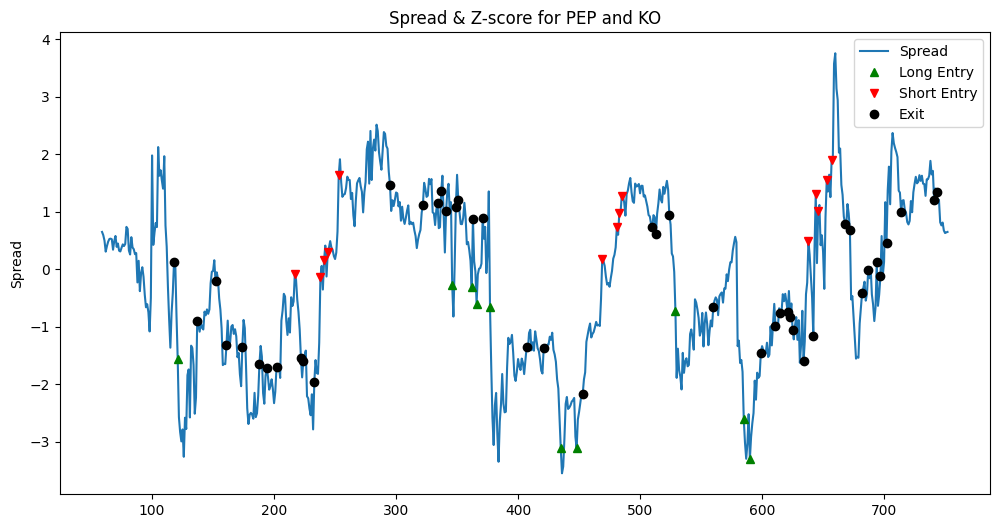

   entry_type  entry_index  exit_index  gross_return  fees  net_return
0        long           62          78      0.015197   0.0    0.015197
1       short          158         163      0.014412   0.0    0.014412
2       short          179         236      0.006746   0.0    0.006746
3        long          287         290      0.016338   0.0    0.016338
4        long          303         304     -0.003591   0.0   -0.003591
5        long          307         312      0.021010   0.0    0.021010
6        long          318         348     -0.019191   0.0   -0.019191
7        long          376         394     -0.015487   0.0   -0.015487
8       short          410         451      0.120507   0.0    0.120507
9        long          470         501      0.048681   0.0    0.048681
10       long          526         540     -0.013597   0.0   -0.013597
11      short          579         583      0.006370   0.0    0.006370
12      short          585         609      0.041786   0.0    0.041786
Sharpe

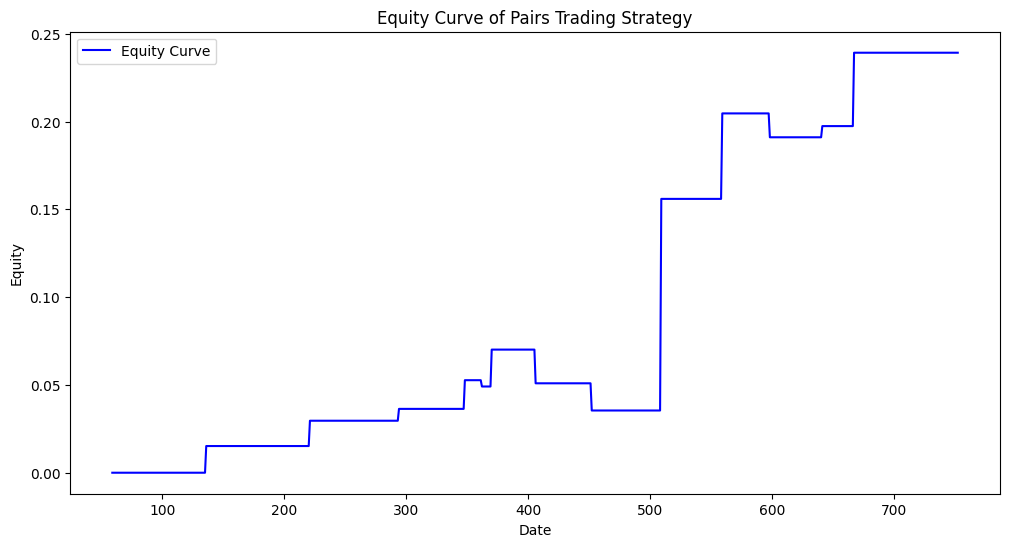

In [166]:


testX = close[symbol1].to_numpy()
testY = close[symbol2].to_numpy()
testResiduals = testY - (beta[0] + beta[1] * testX)
testResiduals = pd.Series(testResiduals)
testResiduals = zscore(testResiduals)
testResiduals = testResiduals.dropna()
backtest_results = backtest(testResiduals)
# print signals
for i, row in backtest_results.iterrows():
    print(f"Date: {i}, Z-score: {row['zscore']:.2f}, Long Entry: {row['long_entry']}, Short Entry: {row['short_entry']}, Exit: {row['exit']}")
# Simulate trading based on the backtest results
results, trades, performance = simulate_trading(backtest_results, close, symbol1, symbol2, beta[1], slippage=0.0, fees=0.0, interval=timeInterval)
plot_spread_and_signals(testResiduals, backtest_results, title=f"Spread & Z-score for {symbol1} and {symbol2}")
print(trades)
print(f"Sharpe Ratio: {performance['sharpe_ratio']}")
print(f"Max Drawdown: {performance['max_drawdown']}")
print(f"Number of Trades: {performance['num_trades']}")
print(f"Total return: {performance['total_return']}")
plt.figure(figsize=(12, 6))
plt.plot(results['equity'], label='Equity Curve', color='blue')
plt.title('Equity Curve of Pairs Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.show() 